# Лабораторная работа 7. Управление ресурсами в однопроцессорной системе с неоднородными заявками

## Вариант 2

##### Выполнил: Борисочкин М. И. РТ5-81Б

In [ ]:
# Генерация начальных условий
Variant <- 2
set.seed(Variant) 

m <- sample(c(6:20), 1)
lambda <- runif(1, 0.1, 2)
Q <- rexp(m, 0.3)
q <- sample(c(1:4), 1)
View(data.frame(m, q, lambda))
print(Q)

m,q,lambda
<int>,<int>,<dbl>
10,3,1.434511


 [1] 0.4888422 5.7690324 0.2984206 2.2229921 3.5812229 5.0387643 4.3809197
 [8] 0.5217676 2.4837299 4.1444845


### Теоритическая часть

In [ ]:
# Интенсивность обслуживания
mu <- 1/mean(Q) 
mu

[1] 0.3456598

In [ ]:
# Нагрузка системы
y <- lambda/mu
y

[1] 4.150065

Так нагрузка системы ($y$) вышла бельше единицы, то изменим интенсивность входящего потока ($λ$)

In [ ]:
# Новое значение интенсивности поступления программ
set.seed(Variant) 
lambda <- runif(1, 0.1, 1)
lambda

[1] 0.266394

In [ ]:
# Нагрузка системы
y <- lambda/mu
y

[1] 0.7706826

In [ ]:
# Cреднее время обслуживания программ
Tsys <- 1/mu/(1 - y)
Tsys

[1] 12.61578

### Экспериментальная часть

In [ ]:
# Установка библиотеки
install.packages("simmer", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘downloader’, ‘htmlwidgets’, ‘igraph’, ‘influenceR’, ‘viridis’, ‘visNetwork’, ‘DiagrammeR’, ‘Rcpp’, ‘BH’, ‘simmer.plot’, ‘rticles’




In [ ]:
# Подключение библиотеки
library("simmer")

In [ ]:
set.seed(Variant)

# Создание траектории программ
m.queue <- trajectory() %>%
  seize("server", amount=1) %>% # Занятие сервера
  timeout(function() rexp(1, mu)) %>% # Обслуживание программы
  release("server", amount=1) # Освобождение сервера

# Создание окружения симуляции
mm.env <- simmer() %>%
  add_resource("server", capacity=1, queue_size=Inf) %>% # Создание ресурса "Сервер"
  add_generator("program", m.queue, function() rexp(1, lambda)) %>% # Создание потока программ
  run(until=45000)

# Проведение 20 экспериментов
mm.envs <- lapply(1:20, function(i) {mm.env})

In [ ]:
# Cреднее время обслуживания программ
programsData <- get_mon_arrivals(mm.envs)
mean(programsData$end_time - programsData$start_time)

[1] 12.5839

### Алгоритм Shortest-processing-task-first

In [ ]:
# Генерация очереди программ
set.seed(Variant)
n <- 45000 # Размер очереди программ
programs <- sample(Q, n, replace = TRUE)
head(programs)

[1] 3.5812229 5.0387643 5.0387643 0.5217676 0.4888422 0.4888422

In [ ]:
# Сортировка программ по времени выполнения (SRT)
programsSorted <- sort(programs)
head(programsSorted)

[1] 0.2984206 0.2984206 0.2984206 0.2984206 0.2984206 0.2984206

In [ ]:
# Создание и заполнение таблицы времён начала и конца обслуживания каждой программы
timeperiods <- data.frame()
timeperiods <- rbind(timeperiods, c(0, programsSorted[1]))
colnames(timeperiods) <- c("start time", "end time")

for(i in 2:n)
{
  timeperiods[i:n, 1] <- timeperiods[i - 1, 1] + programsSorted[i - 1]
  timeperiods[i, 2] <- timeperiods[i, 1] + programsSorted[i]
}

head(timeperiods, 10)

,start time,end time
,<dbl>,<dbl>
1,0.0000000,0.2984206
2,0.2984206,0.5968412
3,0.5968412,0.8952618
4,0.8952618,1.1936824
5,1.1936824,1.4921030
6,1.4921030,1.7905236
7,1.7905236,2.0889442
8,2.0889442,2.3873648
9,2.3873648,2.6857854


In [ ]:
# Cреднее время обслуживания программ по методу SPT
Tspt <- sum(timeperiods$`end time` - timeperiods$`start time`)/n
Tspt

[1] 2.899172

Использование алгоритма SPT позволило уменьшить среднее время обслуживания программ в 4 раза, в сравнении с обычным поступлением программ.

### Алгоритм Round Robin

In [ ]:
# Создание и заполнение таблицы времён начала и конца обслуживания каждой программы
programsRR <- programs
timeperiodsRR <- data.frame()

if(programsRR[1] > q) { # Обработка первой строки
  timeperiodsRR <- rbind(timeperiodsRR, c(0, q))
  programsRR <- append(programsRR, programsRR[1] - q)

} else {
  timeperiodsRR <- rbind(timeperiodsRR, c(0, programsRR[1]))
}

colnames(timeperiodsRR) <- c("start time", "end time")

for(i in 2:(round(n*1.5, 0)))
{
  timeperiodsRR[i, 1] <- timeperiodsRR[i - 1, 2]

  if(programsRR[i] > q && !is.na(programsRR[i])) { # Случай больше кванта времени
     timeperiodsRR[i, 2] <- timeperiodsRR[i, 1] + q
     programsRR <- append(programsRR, programsRR[i] - q)
  } else {
    timeperiodsRR[i, 2] <- timeperiodsRR[i, 1] + programsRR[i]
  }
}
head(timeperiodsRR, 10)

,start time,end time
,<dbl>,<dbl>
1,0.000000,3.000000
2,3.000000,6.000000
3,6.000000,9.000000
4,9.000000,9.521768
5,9.521768,10.010610
6,10.010610,10.499452
7,10.499452,12.983182
8,12.983182,15.983182
9,15.983182,16.472024


In [ ]:
# Размер таблицы до начала NA
lengthNotNA <- min(length(timeperiodsRR$`end time`[!is.na(timeperiodsRR$`end time`)]), 
length(timeperiodsRR$`start time`[!is.na(timeperiodsRR$`start time`)]))
lengthNotNA

[1] 67484

In [ ]:
# Cреднее время обслуживания программ по методу RR
Trr <- sum(timeperiodsRR$`end time`[1:lengthNotNA] - timeperiodsRR$`start time`[1:lengthNotNA])/n
Trr

[1] 2.899172

Среднее время обслуживания программ по алгоритму RR с квантом времени 3 совпалов с аналогичным, полученным с помощью алгоритма SPT

Теперь проверим как влияет значение кванта времени на среднее время обслуживания

In [ ]:
# Функция расчёта среднего времени ожидания при заданных кванте времени и длине очереди программ
estimatetimeQ <- function(quant, size)
{
  programsRR <- programs[1:size]
  timeperiodsRR <- data.frame()

  if(programsRR[1] > quant) { # Обработка первой строки
    timeperiodsRR <- rbind(timeperiodsRR, c(0, quant))
    programsRR <- append(programsRR, programsRR[1] - quant)

  } else {
    timeperiodsRR <- rbind(timeperiodsRR, c(0, programsRR[1]))
  }

  colnames(timeperiodsRR) <- c("start time", "end time")

  for(i in 2:(round(size*4, 0)))
  {
    timeperiodsRR[i, 1] <- timeperiodsRR[i - 1, 2]

    if(programsRR[i] > quant && !is.na(programsRR[i])) { # Случай больше кванта времени
      timeperiodsRR[i, 2] <- timeperiodsRR[i, 1] + quant
      programsRR <- append(programsRR, programsRR[i] - quant)
    } else {
      timeperiodsRR[i, 2] <- timeperiodsRR[i, 1] + programsRR[i]
    }
  }

  # Размер таблицы до начала NA
  lengthNotNA <- min(length(timeperiodsRR$`end time`[!is.na(timeperiodsRR$`end time`)]), 
  length(timeperiodsRR$`start time`[!is.na(timeperiodsRR$`start time`)]))
  # Cреднее время обслуживания программ по методу RR
  Trr <- sum(timeperiodsRR$`end time`[1:lengthNotNA] - timeperiodsRR$`start time`[1:lengthNotNA])/size

  return(Trr)
}

In [ ]:
# Получение значений для графика
qVect <- c(1:6)
size <- 45000

Tseries <-c()

for(i in qVect) Tseries <- append(Tseries, estimatetimeQ(i, size))

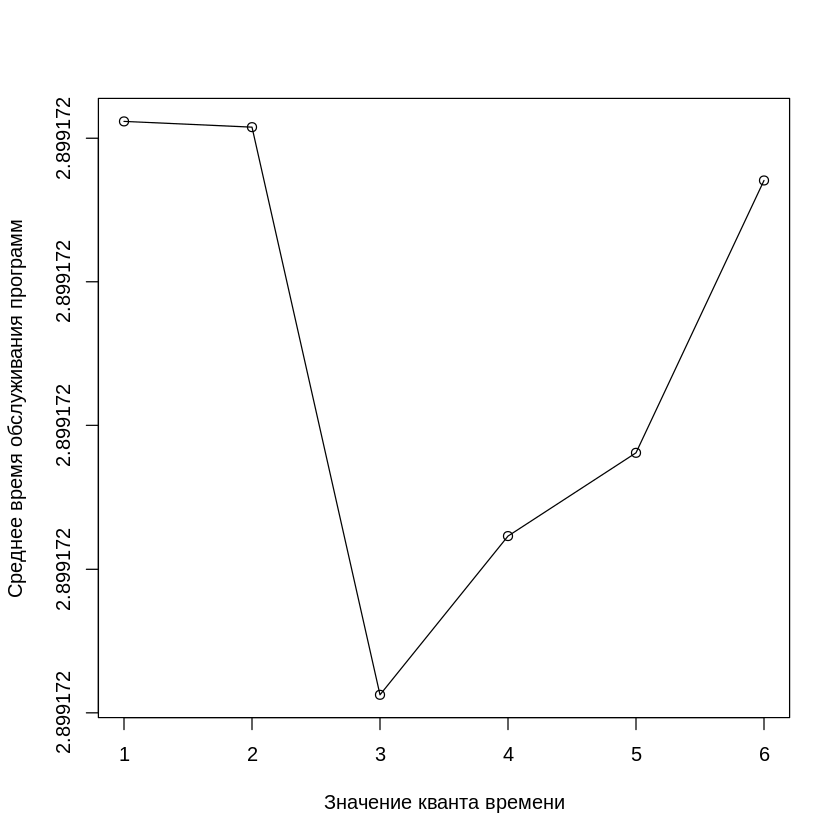

In [ ]:
# График зависимости среднего времени ожидания от кванта времени q
plot(qVect, Tseries, xlab = "Значение кванта времени", ylab = "Cреднее время обслуживания программ", type = "o")

Как видно из графика лучше время ожидания при кванте времени равным 3. Однако, стоит подметить, что разница среднего времени обслуживания с разными квантами времени в данном случае очень невелика.